1. Setup & Load

In [1]:
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

PROC = Path("data/processed")
FIG  = Path("reports/figures"); FIG.mkdir(parents=True, exist_ok=True)
TBL  = Path("reports/tables");  TBL.mkdir(parents=True, exist_ok=True)

ret = (pd.read_csv(PROC/"monthly_returns_gold_btc_2020_2025.csv", parse_dates=["Date"])
         .set_index("Date").sort_index()[["Gold_ret","BTC_ret"]])

# Minimum QC
ret = ret.replace([np.inf, -np.inf], np.nan).dropna()
assert len(ret) >= 24, "Observasi terlalu sedikit untuk robustness; cek tahap 07/08."
n = len(ret); print("N months:", n, "|", ret.index.min().date(), "→", ret.index.max().date())


N months: 66 | 2020-02-29 → 2025-07-31


2. Pearson (Fisher & Bootstrap CI) + Spearman

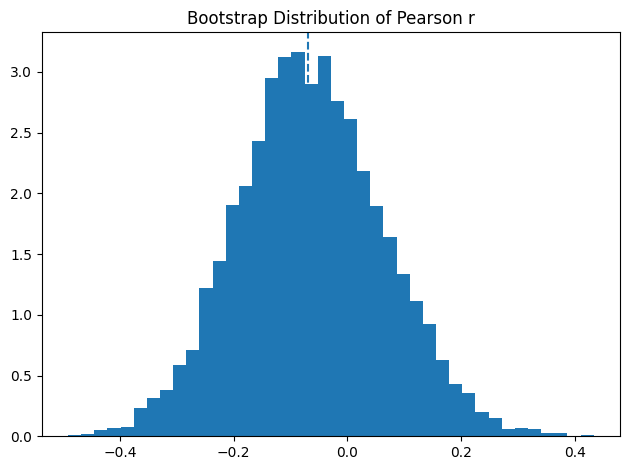

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_correlation.csv


In [2]:
# Pearson + Fisher CI
r, p = stats.pearsonr(ret["Gold_ret"], ret["BTC_ret"])
z = np.arctanh(np.clip(r, -0.999999, 0.999999))
zcrit = stats.norm.ppf(1-0.05/2); se = 1/np.sqrt(n-3)
f_lo, f_hi = np.tanh([z - zcrit*se, z + zcrit*se])

# Bootstrap CI (non-parametric)
def bootstrap_corr(x, y, B=5000, seed=42):
    rng = np.random.default_rng(seed)
    idx = np.arange(len(x)); rs = np.empty(B)
    xv, yv = x.to_numpy(), y.to_numpy()
    for b in range(B):
        s = rng.choice(idx, size=len(idx), replace=True)
        rs[b] = np.corrcoef(xv[s], yv[s])[0,1]
    lo, hi = np.percentile(rs, [2.5, 97.5])
    return rs, lo, hi

rs, b_lo, b_hi = bootstrap_corr(ret["Gold_ret"], ret["BTC_ret"])

# Spearman (robust to outliers / non-linear monotone)
rho, p_s = stats.spearmanr(ret["Gold_ret"], ret["BTC_ret"], nan_policy="omit")

pd.DataFrame([{
    "n_months": n,
    "pearson_r": r, "pearson_p": p, "fisher_ci_lo": f_lo, "fisher_ci_hi": f_hi,
    "boot_ci_lo": b_lo, "boot_ci_hi": b_hi,
    "spearman_rho": rho, "spearman_p": p_s
}]).round(6).to_csv(TBL/"robustness_correlation.csv", index=False)

# Bootstrap distribution (optional plot)
plt.figure(); plt.hist(rs, bins=40, density=True)
plt.axvline(r, ls="--"); plt.title("Bootstrap Distribution of Pearson r")
plt.tight_layout(); plt.savefig(FIG/"bootstrap_corr_hist.png", dpi=150); plt.show()

print("Saved →", (TBL/"robustness_correlation.csv").resolve())


3. Sensitivitas Window & Lead–lag (–3 … +3)

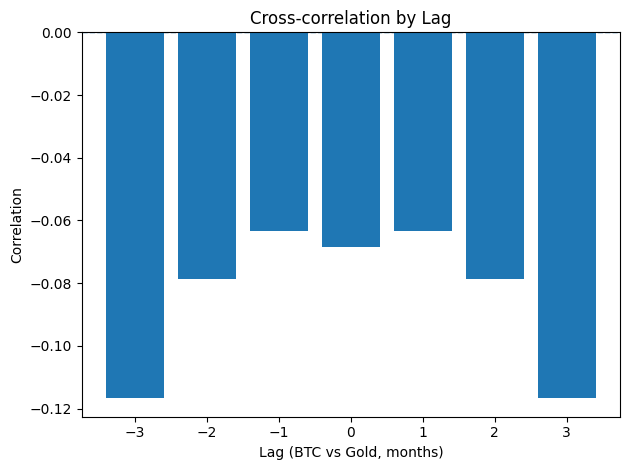

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_rolling_windows.csv | C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_crosscorr_lags.csv


In [3]:
# Rolling windows
rows=[]
for w in (3,6,9,12):
    roll = ret["Gold_ret"].rolling(w).corr(ret["BTC_ret"])
    rows.append({
        "window": w,
        "mean": roll.mean(), "min": roll.min(), "max": roll.max(),
        "frac_negative": roll.lt(0).mean()
    })
pd.DataFrame(rows).round(6).to_csv(TBL/"robustness_rolling_windows.csv", index=False)

# Cross-correlation (BTC vs Gold) at lags –3..+3 (k>0: BTC lags)
lag_rows=[]
for k in range(-3, 4):
    if k >= 0:
        x = ret["Gold_ret"].iloc[k:]; y = ret["BTC_ret"].iloc[:len(ret)-k]
    else:
        k2 = -k
        x = ret["Gold_ret"].iloc[:len(ret)-k2]; y = ret["BTC_ret"].iloc[k2:]
    df = pd.concat([x,y], axis=1).dropna()
    if len(df) >= 3:
        rr, pp = stats.pearsonr(df.iloc[:,0], df.iloc[:,1])
        lag_rows.append({"lag_btc_vs_gold": k, "n": len(df), "r": rr, "p_value": pp})
lags_tab = pd.DataFrame(lag_rows).round(6)
lags_tab.to_csv(TBL/"robustness_crosscorr_lags.csv", index=False)

# Cross-correlation bar plot
plt.figure()
plt.bar(lags_tab["lag_btc_vs_gold"], lags_tab["r"])
plt.axhline(0, ls="--", lw=1); plt.xlabel("Lag (BTC vs Gold, months)")
plt.ylabel("Correlation"); plt.title("Cross-correlation by Lag")
plt.tight_layout(); plt.savefig(FIG/"crosscorr_lags.png", dpi=150); plt.show()

print("Saved →", (TBL/"robustness_rolling_windows.csv").resolve(), "|", (TBL/"robustness_crosscorr_lags.csv").resolve())


4. Outlier Influence: Winsorize 1% & Jackknife

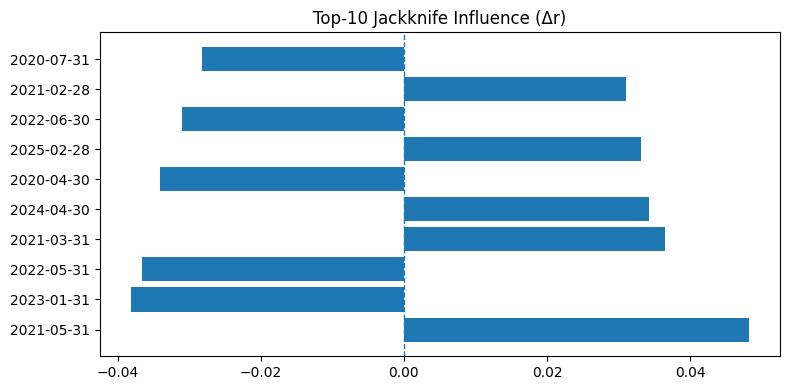

Saved → C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_outliers_influence.csv | C:\Users\Noveno\OneDrive\CA1-BTC-Gold-Correlation\reports\tables\robustness_jackknife_all.csv


In [4]:
# Winsorize 1% (robust to tails)
def winsorize(s, q=0.01):
    lo, hi = s.quantile(q), s.quantile(1-q)
    return s.clip(lo, hi)

ret_w = ret.assign(
    Gold_ret = winsorize(ret["Gold_ret"]),
    BTC_ret  = winsorize(ret["BTC_ret"])
)
r_w, p_w = stats.pearsonr(ret_w["Gold_ret"], ret_w["BTC_ret"])

# Jackknife (leave-one-month-out influence)
jk_rows=[]
for i, ts in enumerate(ret.index):
    sub = ret.drop(index=ts)
    if len(sub) >= 3:
        r_i, _ = stats.pearsonr(sub["Gold_ret"], sub["BTC_ret"])
        jk_rows.append({"drop_month": ts.date(), "r_without": r_i, "delta": r_i - r})
jk = pd.DataFrame(jk_rows).sort_values("delta")

# Summary and export
pd.DataFrame([{
    "pearson_r_original": r, "pearson_r_winsor1pct": r_w,
    "delta_winsor": r_w - r,
    "jackknife_min_r": jk["r_without"].min(), "jackknife_max_r": jk["r_without"].max(),
    "jackknife_min_delta": jk["delta"].min(), "jackknife_max_delta": jk["delta"].max()
}]).round(6).to_csv(TBL/"robustness_outliers_influence.csv", index=False)
jk.round(6).to_csv(TBL/"robustness_jackknife_all.csv", index=False)

# Visual 10 biggest influences (abs delta)
top = jk.reindex(jk["delta"].abs().sort_values(ascending=False).index[:10]).copy()
plt.figure(figsize=(8,4))
plt.barh(top["drop_month"].astype(str), top["delta"])
plt.axvline(0, ls="--", lw=1); plt.title("Top-10 Jackknife Influence (Δr)")
plt.tight_layout(); plt.savefig(FIG/"jackknife_top10.png", dpi=150); plt.show()

print("Saved →", (TBL/"robustness_outliers_influence.csv").resolve(), "|", (TBL/"robustness_jackknife_all.csv").resolve())
